# Proximinal Policy Optimization

#### Papers Involved
- Proximal Policy Optimization Algorithms: https://arxiv.org/pdf/1707.06347.pdf
- Playing Atari with Deep Reinforcement Learning: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
- REINFORCE: http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf

#### Online Resources
- https://medium.freecodecamp.org/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d
- https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12
- https://github.com/dennybritz/reinforcement-learning/issues/34

#### Repos for Inspiration
- https://github.com/OctThe16th/PPO-Keras
- https://github.com/hill-a/stable-baselines
- https://github.com/rlcode/reinforcement-learning

#### Imports

We're using `Keras` with the Tensorflow backend to handle the neural networks.  `Numpy` is used for various tensor operations.

`Matplotlib`, `Gym`, and `Pandas` aren't required for the PPO algorithm.  They are only used for visualization/testing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


#### Test Environment

In order to test this algorithm, we've created a very simple environment that should be easy for a working agent to solve.  This isn't necessary for the PPO implementation, and is only used for testing.

In [2]:
class Environment:
    """ This is a very simple custom environment used for debugging and testing.
    The observation at timestep t is sin(2*t*pi/20)
    The agent starts at position 0
    The action space is one of 3 discrete moves:
        0: add 0.25 to the agent's position
        1: subtract 0.25 from the agent's position
        2: don't do anything
    
    The agent is rewarded +1 if, after moving, it's position at timestep t is within
    a distance of 0.25 from the observation.
    The agent is punished with -1 if, after moving, it's position is outside
    a distance of 0.5 from the observation.
    Otherwise, a reward of 0 is given.
    
    The environment terminates when the step hits max_steps (default 20)
    """
    def __init__(self):
        self.n_actions = 3
        self.n_obs = 2
        self.max_steps = 20
        self.space = np.sin(np.linspace(0,2*np.pi,self.max_steps))
        
    def reset(self):
        self.x = 0
        self.target = self.space[self.x]
        self.agent = self.space[self.x]
        self.state = [self.target, self.agent]
        
        self.x_data = []
        self.target_data = []
        self.agent_data = []
        return np.array(self.state)
    
    def step(self, action):
        self.x += 1
        self.target = self.space[self.x]
        if action == 0:
            pass
        if action == 1:
            self.agent += 0.25
        if action == 2:
            self.agent -= 0.25
            
        self.state = [self.target, self.agent]
        
        dist = abs(self.target - self.agent)
        reward = 0
        if dist < 0.25:
            reward = 1.
        if dist > 0.5:
            reward = -1.
            
        done = False
        if self.x >= self.max_steps - 1:
            done = True
            
        self.x_data.append(self.x)
        self.target_data.append(self.target)
        self.agent_data.append(self.agent)
            
        return np.array(self.state), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.target_data, self.agent_data
    
    def render(self):
        plt.plot(self.x_data, self.target_data, '.')
        plt.plot(self.x_data, self.agent_data, '.')
        plt.show()

## PPO Agent

Here is where we build the algorithm into an `Agent` class.

When we initialize the agent, this creates two models: an actor and a critic

#### Actor:
    - uses the agent's `proximal_policy_optimization_loss` as it's loss function
    - accepts three inputs: the state (observation), the old probability predicition, and the advantage
    - outputs a vector: the probability distribution of actions
#### Critic:
    - uses plain MSE as loss
    - accepts the state (observation) as input
    - outputs a scalar: the advantage

Otherwise, the networks are just relatively simple feed forward networks

In [34]:
class Agent:
    def __init__(self, n_obs, n_actions,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        K.clear_session()
        self.n_obs = n_obs
        self.n_actions = n_actions
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 
        self.critic = self.build_critic()
        
        # When we want predictions of actions, we need to pass in three things:
        # the observation, the old prob, and the advantage.
        # Here, we just created data to spoof the last two.
        self.DUMMY_ACTION, self.DUMMY_VALUE = np.zeros((1, self.n_actions)), np.zeros((1, 1))

    def proximal_policy_optimization_loss(self, advantage, old_pred, debug=True):
        
        # Defines the PPO loss to be used during actor optimization
        def loss(y_true, y_pred):
            
            # advantage is a vector of size 1 passed in from the critic
            # This summing flattens it
            adv = K.sum(advantage, axis=1)
            if debug:
                adv = K.print_tensor(adv, 'advantage     :')

            # y_true is one-hot vector denoting the action taken
            # y_pred is the output of the actor neural network
            # for the given observation
            # e.g., y_true = [0,1,0], y_pred = [0.2, 0.5, 0.3]
            # so prob = y_true * y_pred = [0, 0.5, 0]
            prob = y_true * y_pred
            if debug:
                prob = K.print_tensor(prob, 'prob          :')

            # old_pred is the actor's previous probabilty distribution
            # for the given observation
            # e.g., y_true = [0,1,0], old_pred = [0.2, 0.4, 0.4]
            # so prob = y_true * old_pred = [0, 0.4, 0]
            old_prob = y_true * old_pred
            if debug:
                old_prob = K.print_tensor(old_prob, 'old_prob      :')

            # r is the ratio of the old probability to the new one
            # e.g., r = prob/old_prob = [0, 0.5/0.4, 0]
            r = K.sum(prob/(old_prob + 1e-10), axis=1)
            if debug:
                r = K.print_tensor(r, 'r             :')

            # clipped is the value of r clipped between 1 +/- epsilon
            # e.g., r = 1.4, epsilon = 0.2 => clipped = 1.2
            clipped = K.clip(r, min_value=1-self.epsilon, max_value=1+self.epsilon)
            if debug:
                clipped = K.print_tensor(clipped, 'clipped       :')

            # minimum is the min of r * advantage and clipped * advantage
            minimum = K.minimum(r * adv, clipped * adv)
            if debug:
                minimum = K.print_tensor(minimum, 'minimum       :')

            # entropy bonus (to encourage exploration)
            entropy_bonus = self.entropy_loss * (prob * K.log(prob + 1e-10))
            entropy_bonus = K.sum(entropy_bonus, axis=1)
            if debug:
                entropy_bonus = K.print_tensor(entropy_bonus, 'entropy_bonus :')

            # K.mean computes the mean over all dimensions (left with a scaler)
            result = -K.mean(minimum + entropy_bonus)
            if debug:
                result = K.print_tensor(result, 'result        :')

            return result
        return loss
    
    def build_actor(self):
        # actor has three inputs: the current state, the advantage,
        # and the agent's predicted probability for the given observation
        state_inputs = Input(shape=(self.n_obs,))
        advantage = Input(shape=(1,))
        old_pred = Input(shape=(self.n_actions,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # the output is a probability distribution over the actions
        out_actions = Dense(self.n_actions, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_pred],
                      outputs=[out_actions])
        
        # compile the model using our custom loss function
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_pred=old_pred
                      )])
        return model
    
    def build_critic(self):
        # critic recieves the observation as input
        state_inputs = Input(shape=(self.n_obs,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # we predict the value of the current observation
        # i.e., cumulative discounted reward
        predictions = Dense(1, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model
    
    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        prob = self.actor.predict([observation.reshape(1,self.n_obs), 
                                   self.DUMMY_VALUE, 
                                   self.DUMMY_ACTION])
        prob = prob.flatten()
        
        # Sample an action as a scaler
        action = np.random.choice(self.n_actions, 1, p=prob)[0]
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.n_actions)
        action_vector[action] = 1
        
        return action, action_vector, prob
    
    def train_batch(self, observations, actions, probabilities, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        acts = actions[:self.buffer_size]
        probs = probabilities[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        
        # our 'old probs' are really just the batches probs
        old_probs = probs
        
        # Calculate advantages
        values = self.critic.predict(obs)
        advs = rews - values
            
        # Train the actor and critic on the batch data
        self.actor.fit([obs, advs, old_probs], [acts],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=self.batch_size, shuffle=True,
                        epochs=self.epochs, verbose=False)
    
    def run(self, env, episodes, verbose=False):
        episode = 0
        reward_history = []

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                action, action_vector, prob = self.get_action(observation)

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(action)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['action_vector'].append(action_vector)
                tmp_batch['probability'].append(prob)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                        tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        act = tmp_batch['action_vector'][i]
                        prob = tmp_batch['probability'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs)
                        batch['action_vector'].append(act)
                        batch['probability'].append(prob)
                        batch['reward'].append(r)

                    # if we're using my custom environment,
                    # we record some more data for plotting
                    try:
                        x_data, target_data, agent_data = env.get_render_data()
                    except:
                        pass

                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'action_vector': [],
                        'probability': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1

            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            actions = np.array(batch['action_vector'])
            probabilities = np.array(batch['probability'])
            rewards = np.array(batch['reward'])    
            rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, actions, probabilities, rewards)

            # every 10th episode, log some stuff
            if (episode % 10 == 0 or episode == episodes - 1) and verbose:
                print('Episode:', episode)
                print('Reward :', reward_data)
                print('Average:', np.mean(reward_history[-100:]))
                print('-'*10)
                print()
                
                try:
                    plt.plot(x_data, target_data, '.')
                    plt.plot(x_data, agent_data, '.')
                    plt.show()
                except:
                    pass
                    
        self.reward_history = reward_history
        return self.reward_history

Episode: 70
Reward : -10.0
Average: -6.742857142857143
----------



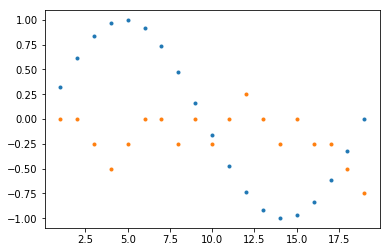

Episode: 140
Reward : 6.0
Average: -0.28
----------



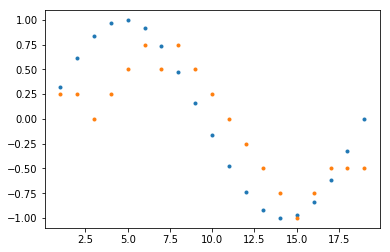

Episode: 210
Reward : 9.0
Average: 7.76
----------



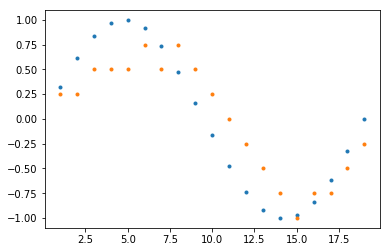

Episode: 280
Reward : 17.0
Average: 11.31
----------



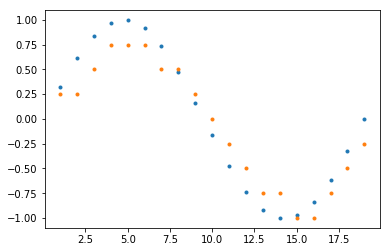

Episode: 350
Reward : 14.0
Average: 13.93
----------



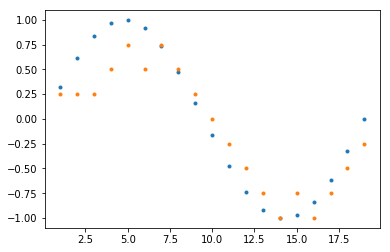

Episode: 420
Reward : 17.0
Average: 15.34
----------



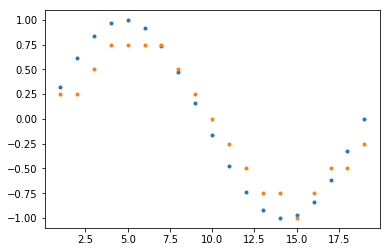

Episode: 490
Reward : 18.0
Average: 16.93
----------



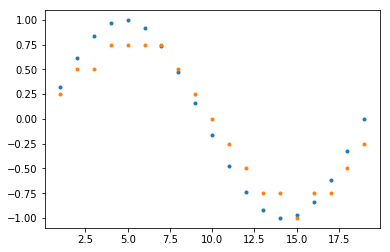

Episode: 560
Reward : 18.0
Average: 16.3
----------



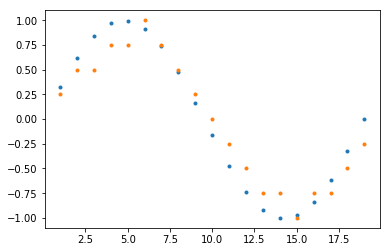

Episode: 630
Reward : 18.0
Average: 16.95
----------



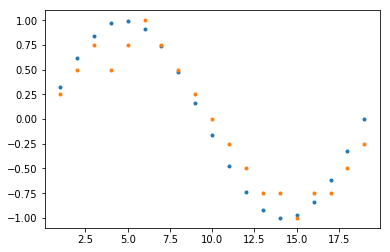

Episode: 700
Reward : 17.0
Average: 17.54
----------



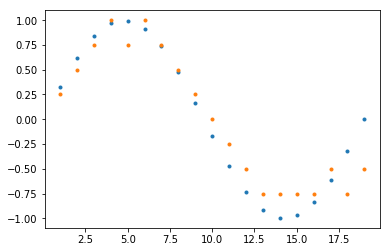

Episode: 770
Reward : 13.0
Average: 17.14
----------



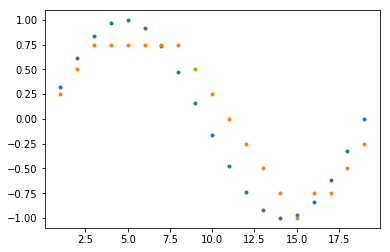

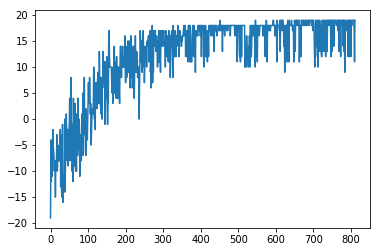

In [35]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
rh = agent.run(env, 800, verbose=True)

pd.Series(rh).plot()

Session: 0
Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9


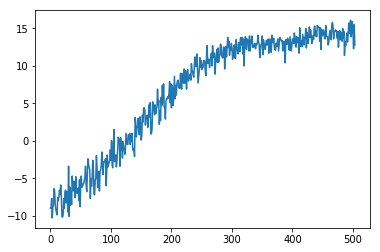

In [16]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions

rhs = []
for i in range(10):
    print("Session:", i)
    agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
    rh = agent.run(env, 500)
    rhs.append(pd.Series(rh))
        
pd.concat(rhs, axis=1).mean(axis=1).plot()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Session: 0
Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9


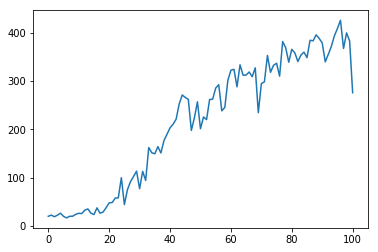

In [15]:
env_names = ['CartPole-v1', 'LunarLander-v2','Acrobot-v1', 'MountainCar-v0']
env = gym.make(env_names[0])
NUM_OBS = env.observation_space.shape[0]
NUM_ACTS = env.action_space.n

rhs = []
for i in range(10):
    print("Session:", i)
    agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
    rh = agent.run(env, 100)
    rhs.append(pd.Series(rh))
        
pd.concat(rhs, axis=1).mean(axis=1).plot()